# Deep Fakes (3/3) - Face Swapping stage

This notebook is part of a group of notebooks that together belong to a Deep Fakes article. I try to teach all of you how to build Autoencoders for Deep Fakes from scratch.

In this particular notebook, I'll go through several steps to extract frames from a video, extract faces from them, use encoders and decoders obtained in [a previous notebook](https://www.kaggle.com/sergiovirahonda/deepfakes-model-training) in order to transform those faces into new ones with their particular features but with the facial expressions from the source faces. At the end, I'll swap faces in the source images with the respective transformed ones and rebuild the video.

# Imports

In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow
from tensorflow.keras.models import load_model
import gc
import matplotlib.pyplot as plt
import cv2
import os
import dlib
from IPython.display import clear_output

# Directories creation

In [2]:
!cd /kaggle/working/
!mkdir frames
!mkdir results
!mkdir transformed
!mkdir final
!ls /kaggle/working/

__notebook__.ipynb  final  frames  results  transformed


# Frames extraction

In [3]:
input_path = '/kaggle/input/presidentsdataset/presidents/trump1.mp4'
output_path = '/kaggle/working/frames/'

def extract_frames(input_path,output_path):
    videocapture = cv2.VideoCapture(input_path)
    success,image = videocapture.read()
    count = 0
    while success:
        cv2.imwrite(output_path+"%d.jpg" % count, image)     
        success,image = videocapture.read()
        count += 1
    print('Frames extraction has ended')
    return count

frames = extract_frames(input_path,output_path)

Frames extraction has ended


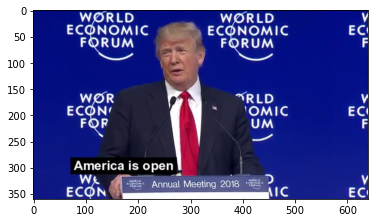

In [4]:
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/working/frames/120.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Faces extraction

In [5]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 910 kB/s 


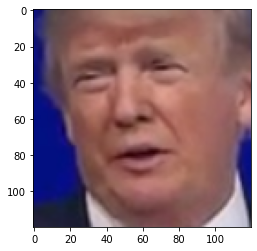

In [6]:
from mtcnn import MTCNN
import cv2
 
detector = MTCNN()
image = cv2.imread('/kaggle/working/frames/120.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detections = detector.detect_faces(image)
x, y, width, height = detections[0]['box']
x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
face = image[y1:y2, x1:x2]
#face = cv2.resize(face, (170, 170), interpolation=cv2.INTER_AREA) #if shape is > 120x120
face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
plt.imshow(face)
plt.show()

In [7]:
def extract_faces(source,destination,detector):
    counter = 0
    for dirname, _, filenames in os.walk(source):
        for filename in filenames:
            try:
                image = cv2.imread(os.path.join(dirname, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                detections = detector.detect_faces(image)
                x, y, width, height = detections[0]['box']
                x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
                face = image[y1:y2, x1:x2]
                face = cv2.resize(face, (120, 120), interpolation=cv2.INTER_LINEAR)
                plt.imsave(os.path.join(destination,filename),face)
                clear_output(wait=True)
                print("Extraction progress: "+str(counter)+"/"+str(len(filenames)-1))
            except:
                pass
            counter += 1

In [8]:
detector = MTCNN()
extract_faces('/kaggle/working/frames/', '/kaggle/working/results/',detector)

Extraction progress: 1700/1700


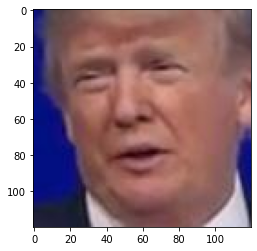

In [9]:
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/working/results/120.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Faces transformation

In [10]:
autoencoder_a = load_model("/kaggle/input/deepfakes-model-training/autoencoder_a.hdf5")
autoencoder_b = load_model("/kaggle/input/deepfakes-model-training/autoencoder_b.hdf5")

In [11]:
# LOADING THE ENCODER A
encoder_a = keras.Model(autoencoder_a.layers[1].input, autoencoder_a.layers[1].output)
# LOADING THE DECODER B
decoder_b = keras.Model(autoencoder_b.layers[2].input, autoencoder_b.layers[2].output)

In [12]:
def face_transform(source,destination,encoder,decoder):
    counter = 0
    for dirname, _, filenames in os.walk(source):
        for filename in filenames:
            # load the image
            try:
                image = cv2.imread(os.path.join(source, filename))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = image.astype('float32')
                image /= 255.0
                image = encoder.predict(np.array([image]))
                image = decoder.predict(image)
                image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
                image = image.astype(np.uint8)
                plt.imsave(os.path.join(destination,filename),image[0])
                counter += 1
                clear_output(wait=True)
                print("Transformation progress: "+str(counter)+"/"+str(len(filenames)))
            except:
                print('exception')
                pass

In [13]:
face_transform('/kaggle/working/results/','/kaggle/working/transformed',encoder_a,decoder_b)

Transformation progress: 1701/1701


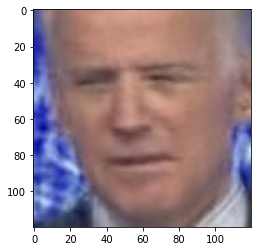

In [14]:
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/working/transformed/120.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Face swapping

## Cloning the script to swap faces

In [15]:
!git clone https://github.com/matthewearl/faceswap.git

Cloning into 'faceswap'...
remote: Enumerating objects: 32, done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 32
Unpacking objects: 100% (32/32), done.


In [16]:
!ls /kaggle/working/faceswap

LICENSE  README.md  faceswap.py


## Making some modifications to make the script runnable in the Notebook

In [17]:
%%writefile ./faceswap/faceswap.py
# %load ./faceswap/faceswap.py
#!/usr/bin/python

# Copyright (c) 2015 Matthew Earl
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
#     The above copyright notice and this permission notice shall be included
#     in all copies or substantial portions of the Software.
# 
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
#     OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
#     MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN
#     NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
#     DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
#     OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE
#     USE OR OTHER DEALINGS IN THE SOFTWARE.

"""
This is the code behind the Switching Eds blog post:

    http://matthewearl.github.io/2015/07/28/switching-eds-with-python/

See the above for an explanation of the code below.

To run the script you'll need to install dlib (http://dlib.net) including its
Python bindings, and OpenCV. You'll also need to obtain the trained model from
sourceforge:

    http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2

Unzip with `bunzip2` and change `PREDICTOR_PATH` to refer to this file. The
script is run like so:

    ./faceswap.py <head image> <face image>

If successful, a file `output.jpg` will be produced with the facial features
from `<head image>` replaced with the facial features from `<face image>`.

"""

import cv2
import dlib
import numpy

import sys

PREDICTOR_PATH = '../input/shape-predictor-68-face-landmarksdat/shape_predictor_68_face_landmarks.dat' #Modifying path to right one
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = numpy.zeros(im.shape[:2], dtype=numpy.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = numpy.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im
    
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:

        sum ||s*R*p1,i + T - p2,i||^2

    is minimized.

    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(numpy.float64)
    points2 = points2.astype(numpy.float64)

    c1 = numpy.mean(points1, axis=0)
    c2 = numpy.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = numpy.std(points1)
    s2 = numpy.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = numpy.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return numpy.vstack([numpy.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         numpy.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = numpy.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * numpy.linalg.norm(
                              numpy.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              numpy.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(numpy.float64) * im1_blur.astype(numpy.float64) /
                                                im2_blur.astype(numpy.float64))

im1, landmarks1 = read_im_and_landmarks(sys.argv[1])
im2, landmarks2 = read_im_and_landmarks(sys.argv[2])

M = transformation_from_points(landmarks1[ALIGN_POINTS],
                               landmarks2[ALIGN_POINTS])

mask = get_face_mask(im2, landmarks2)
warped_mask = warp_im(mask, M, im1.shape)
combined_mask = numpy.max([get_face_mask(im1, landmarks1), warped_mask],
                          axis=0)

warped_im2 = warp_im(im2, M, im1.shape)
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

#cv2.imwrite('output.jpg', output_im) #Modifying this line to save images with different names
cv2.imwrite(sys.argv[3], output_im)

Overwriting ./faceswap/faceswap.py


## Swapping faces massively

In [18]:
def massive_face_swap(source,destination,output):
    counter = 0
    for dirname, _, filenames in os.walk(source):
        for filename in filenames:
            current_src = os.path.join(dirname, filename)
            current_dst = os.path.join(destination, filename)
            current_out = os.path.join(output, filename)
            !python /kaggle/working/faceswap/faceswap.py {current_dst} {current_src} {current_out}
            clear_output(wait=True)
            print("Swap progress: "+str(counter)+"/"+str(len(filenames)-1))
            counter += 1

In [19]:
massive_face_swap('./transformed','./frames','./final')

Swap progress: 1700/1700


## Plotting a sample

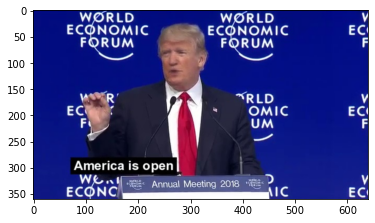

In [20]:
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/working/final/150.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Plotting the original frame

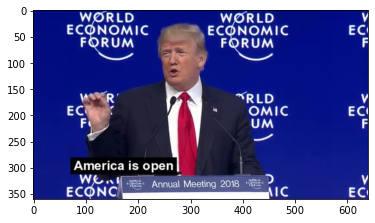

In [21]:
%matplotlib inline
plt.figure()
image = cv2.imread('/kaggle/working/frames/150.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Video rebuilding

In [22]:
frames = []
for i in range(1701):
    image = image = cv2.imread(os.path.join('/kaggle/working/final', str(i)+'.jpg'))
    height, width, layers = image.shape
    frames.append(image)
frames = np.array(frames)
videomaker = cv2.VideoWriter('/kaggle/working/deepfake.avi', cv2.VideoWriter_fourcc(*'DIVX'), 25, (width,height))
 
for frame in frames:
    videomaker.write(frame)

videomaker.release()

In [23]:
!ls /kaggle/working/

__notebook__.ipynb  deepfake.avi  faceswap  final  frames  results  transformed


In [24]:
!zip -r /kaggle/working/output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/__notebook__.ipynb (deflated 30%)
  adding: kaggle/working/deepfake.avi (deflated 1%)
  adding: kaggle/working/faceswap/ (stored 0%)
  adding: kaggle/working/faceswap/LICENSE (deflated 41%)
  adding: kaggle/working/faceswap/README.md (deflated 39%)
  adding: kaggle/working/faceswap/faceswap.py (deflated 59%)
  adding: kaggle/working/faceswap/.git/ (stored 0%)
  adding: kaggle/working/faceswap/.git/config (deflated 34%)
  adding: kaggle/working/faceswap/.git/hooks/ (stored 0%)
  adding: kaggle/working/faceswap/.git/hooks/pre-push.sample (deflated 50%)
  adding: kaggle/working/faceswap/.git/hooks/commit-msg.sample (deflated 44%)
  adding: kaggle/working/faceswap/.git/hooks/pre-applypatch.sample (deflated 38%)
  adding: kaggle/working/faceswap/.git/hooks/prepare-commit-msg.sample (deflated 50%)
  adding: kaggle/working/faceswap/.git/hooks/applypatch-msg.sample (deflated 42%)
  adding: kaggle/working/faceswap/.git/hooks/update.

In [25]:
!rm -rf  /kaggle/working/*.jpg

In case the final output doesn't download, use this link -> 
<a href="./output.zip"> Download File </a>

I hope you've enjoyed this project! See you around :)